In [1]:
from sklearn.datasets import load_boston
from tqdm import tqdm_notebook
from collections import defaultdict
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt

In [28]:
class Node:
    def __init__(self,name,inputs=[],is_trainable=True):
        self.is_trainable=is_trainable
        self.name=name
        self.inputs=inputs
        self.outputs=[]
        for n in self.inputs:
            n.outputs.append(self)
        self.value=None
        self.gradients={}   #loss 对每个节点的偏导


    def forward(self):
        raise NotImplementedError
    def backward(self):
        raise NotImplementedError

    def __repr__(self):
        return self.name
class Placeholder(Node):
    ## repsents for k,b,x,y
    def __init__(self,name,is_trainable=True):
        Node.__init__(self,name=name,is_trainable=is_trainable)
    def forward(self,value=None):
        if value:self.value=value
    def backward(self):
        self.gradients={}
        for n in self.outputs:
            self.gradients[self]=n.gradients[self]*1
class Linear(Node):
    def __init__(self,x=None,weight=None,bias=None,name=None,is_trainable=False):
        Node.__init__(self,name=name,inputs=[x,weight,bias],is_trainable=is_trainable)
    
    def forward(self):
        x_v,k_v,b_v=self.inputs[0].value,self.inputs[1].value,self.inputs[2].value
        self.value=k_v*x_v+b_v
    
    def backward(self):
        x,k,b=self.inputs[0],self.inputs[1],self.inputs[2]
        for output in self.outputs:
            loss_for_linear_gradient=output.gradients[self]
            self.gradients[self]=loss_for_linear_gradient
            self.gradients[x]=loss_for_linear_gradient*k.value
            self.gradients[k]=loss_for_linear_gradient*x.value
            self.gradients[b]=loss_for_linear_gradient*1

class Sigmoid(Node):
    def __init__(self,x,name=None,is_trainable=False):
        Node.__init__(self,inputs=[x],name=name,is_trainable=is_trainable)
        self.x=self.inputs[0]
    def _sigmoid(self,x):
        return 1/(1+np.exp(-1 * x))
    
    def forward(self):
        self.value=self._sigmoid(self.x.value)
    def partial(self):
        return self._sigmoid(self.x.value)*(1-self._sigmoid(self.x.value))
    def backward(self):
        for output in self.outputs:
            loss_for_sigmoid_gradient=output.gradients[self]
            self.gradients[self]=loss_for_sigmoid_gradient
            self.gradients[self.x]=loss_for_sigmoid_gradient*self.partial()

class L2_LOSS(Node):
    def __init__(self,y,yhat,name=None,is_trainable=False):
        Node.__init__(self,inputs=[y,yhat],name=name,is_trainable=is_trainable)
        self.y=y
        self.yhat=yhat
    
    def forward(self):
        self.value= np.mean((self.y.value-self.yhat.value)**2)

    def backward(self):
        y_v=np.array(self.y.value)
        yhat_v=np.array(self.yhat.value)
        self.gradients[self]=1
        self.gradients[self.y]=2*np.mean((y_v-yhat_v))
        self.gradients[self.yhat]=-2*np.mean((y_v-yhat_v))

In [66]:
class MP_1(Node):
    def __init__(self,x=None,weight=None,bias=None,name=None,is_trainable=False):
        Node.__init__(self,name=name,inputs=[x,weight,bias],is_trainable=is_trainable)
    
    def forward(self):
        x_v,k_v,b_v=self.inputs[0].value,self.inputs[1].value,self.inputs[2].value
        self.value=k_v*x_v+b_v
    
    def backward(self):
        x,k,b=self.inputs[0],self.inputs[1],self.inputs[2]
        for output in self.outputs:
            loss_for_MP_1_gradient=output.gradients[self]
            self.gradients[self]=loss_for_MP_1_gradient
            self.gradients[x]=loss_for_MP_1_gradient*k.value
            self.gradients[k]=loss_for_MP_1_gradient*x.value
            self.gradients[b]=loss_for_MP_1_gradient*1
class MP_2(Node):
    def __init__(self,x=None,weight=None,t=None,phi=None,bias=None,name=None,is_trainable=False):
        Node.__init__(self,name=name,inputs=[x,weight,t,phi,bias],is_trainable=is_trainable)
    def forward(self):
        x_v,weight_v,t_v,phi_v,bias_v=self.inputs[0].value,self.inputs[1].value,self.inputs[2].value,self.inputs[3].value,self.inputs[4].value
        self.value=x_v*weight_v*(t_v-phi_v)+bias_v
    def backward(self):
        x=self.inputs[0]
        weight=self.inputs[1]
        t=self.inputs[2]
        phi=self.inputs[3]
        bias=self.inputs[4]
        for output in self.outputs:
            loss_for_MP_2_gradient=output.gradients[self]
            self.gradients[self]=loss_for_MP_2_gradient
            self.gradients[x]=loss_for_MP_2_gradient*weight.value*(t.value-phi.value)
            self.gradients[weight]=loss_for_MP_2_gradient*x.value*(t.value-phi.value)
            self.gradients[t]=loss_for_MP_2_gradient*x.value*weight.value
            self.gradients[phi]=loss_for_MP_2_gradient*(-1)*x.value*weight.value
            self.gradients[bias]=loss_for_MP_2_gradient*1

In [67]:
def convert_feed_dict_to_graph(feed_dict):
    computing_graph=defaultdict(list)

    nodes=[n for n in feed_dict]

    while nodes:
        n = nodes.pop(0)

        if isinstance(n,Placeholder):
            n.value=feed_dict[n]
        
        if n in computing_graph:continue

        for m in n.outputs:
            computing_graph[n].append(m)
            nodes.append(m)
        
    return computing_graph

In [68]:
def toplogic(graph):
    sorted_node=[]

    while(len(graph)>0):
        all_inputs=[]
        all_outputs=[]

        for n in graph:
            all_inputs+=graph[n]
            all_outputs.append(n)
        
        all_inputs=set(all_inputs)
        all_outputs=set(all_outputs)

        need_remove=all_outputs-all_inputs
        
        if len(need_remove)>0:
            node = random.choice(list(need_remove))

            visited_next=[node]
            if len(graph)==1: visited_next+=graph[node]

            graph.pop(node)
            sorted_node+=visited_next

            for _,links in graph.items():
                if node in links:links.remove(node)
        else:
            break
    return sorted_node
        

In [69]:
def optimize(graph,learning_rate=1e-2):
    for node in graph:
        if node.is_trainable:
            #  print("{} start optimize".format(node))
             node.value=node.value+(-1)*node.gradients[node]*learning_rate

def run_one_epoch(graph_order):
    for node in graph_order:
        # print("{} start forward".format(node))
        node.forward()
    for node in graph_order[::-1]:
        # print("{} start backward".format(node))
        node.backward()


In [70]:
def topological_sort_feed_dict(feed_dict):
    graph=convert_feed_dict_to_graph(feed_dict)

    return topologic(graph)

In [91]:
data=load_boston()
X_,y_=data['data'],data['target']
X_rm=X_[:,5]
w1_,b1_=np.random.normal(),np.random.normal()
w2_,b2_=np.random.normal(),np.random.normal()
X_node,y_node=Placeholder(name='X',is_trainable=False),Placeholder(name='Y',is_trainable=False)
w1,b1=Placeholder(name='w1'),Placeholder(name='b1')
w2,b2=Placeholder(name='w2'),Placeholder(name='b2')
output1=Linear(X_node,w1,b1,name='linear-01')
output2=Sigmoid(output1,name='activation')
yhat=Linear(output2,w2,b2,name='yhat')
cost=L2_LOSS(y_node,yhat,name='cost')

feed_dict={
    X_node:X_rm,
    y_node:y_,
    w1:w1_,
    b1:b1_,
    w2:w2_,
    b2:b2_,
}
graph=convert_feed_dict_to_graph(feed_dict)
epoch=500

batch_num=len(X_rm)

valid_order=[X_node,w1,b1,output1,output2,w2,b2,yhat,y_node,cost]
# valid_order=toplogic(graph)
# print(graph)
# print(valid_order)

learning_rate=1e-3
losses=[]
for e in tqdm_notebook(range(epoch)):
    loss=0
    for batch in range(int(batch_num/2)):
        index=np.random.choice(range(len(X_rm)))
        # index=batch
        X_node.value=X_rm[index]
        y_node.value=y_[index]
        run_one_epoch(valid_order)
        optimize(valid_order,learning_rate)
        loss+=cost.value
        # print(cost.value)
    losses.append(loss/batch_num)

In [85]:
np.min(losses)

16.045907168797402

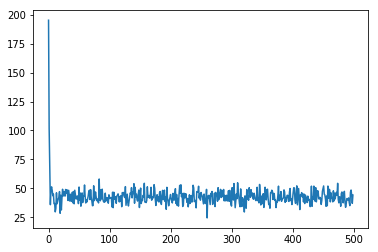

In [92]:
plt.plot(losses)

In [ ]:
 for node in valid_order:
            print("1 {} value is {}".format(node.name,node.value))
        run_one_epoch(valid_order)
        for node in valid_order:
            print("2 {} value is {}".format(node.name,node.value))
        for node in valid_order:
            print("3 {} gradients is {}".format(node.name,node.gradients[node]))
        optimize(valid_order,learning_rate)
        

In [86]:
data=load_boston()
X_,y_=data['data'],data['target']
X_rm=X_[:,5]
w1_,b1_,t1_,phi1_=np.random.normal(),np.random.normal(),np.random.normal(),np.random.normal()
w2_,b2_,t2_,phi2_=np.random.normal(),np.random.normal(),np.random.normal(),np.random.normal()
X_node,y_node=Placeholder(name='X',is_trainable=False),Placeholder(name='Y',is_trainable=False)
w1,b1,t1,phi1=Placeholder(name='w1'),Placeholder(name='b1'),Placeholder(name='t1'),Placeholder(name='phi1')
w2,b2,t2,phi2=Placeholder(name='w2'),Placeholder(name='b2'),Placeholder(name='t2'),Placeholder(name='phi2')
output1=MP_2(X_node,w1,b1,t1,phi1,name='MP_2')
output2=Sigmoid(output1,name='activation')
yhat=MP_2(output2,w2,b2,t2,phi2,name='MP_2 yhat')
cost=L2_LOSS(y_node,yhat,name='cost')

feed_dict={
    X_node:X_rm,
    y_node:y_,
    w1:w1_,
    b1:b1_,
    t1:t1_,
    phi1:phi1_,
    w2:w2_,
    b2:b2_,
    t2:t2_,
    phi2:phi2_
}
graph=convert_feed_dict_to_graph(feed_dict)

epoch=500

batch_num=len(X_rm)

valid_order=[X_node,w1,b1,t1,phi1,output1,output2,w2,b2,t2,phi2,yhat,y_node,cost]

learning_rate=1e-3
losses=[]
for e in tqdm_notebook(range(epoch)):
    loss=0
    for batch in range(int(batch_num/2)):
        index=np.random.choice(range(len(X_rm)))
        # index=batch
        X_node.value=X_rm[index]
        y_node.value=y_[index]
        run_one_epoch(valid_order)
        optimize(valid_order,learning_rate)
        loss+=cost.value
        # print(cost.value)
    losses.append(loss/batch_num)

In [87]:
np.min(losses)

27.672097014947088

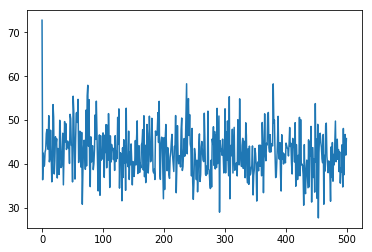

In [88]:
plt.plot(losses)